In [2]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention(attn: np.ndarray,
                        shape=10,
                        row_labels=None,
                        col_labels=None,
                        title="Attention (10x10)",
                        cmap="viridis",
                        annotate=True,
                        vmin=0.0,
                        vmax=1.0,
                        save_path=None):
    """
    可视化 10x10 注意力矩阵。
    attn:       (10, 10) 的 numpy 数组，建议每行归一化到和为1。
    row_labels: 行标签列表（长度10），例如=query tokens
    col_labels: 列标签列表（长度10），例如=key/value tokens
    title:      图标题
    cmap:       颜色映射
    annotate:   是否在格子中标注数值
    vmin/vmax:  颜色范围，注意力通常在[0,1]
    save_path:  若提供，则保存到该路径（如 "attn.png"）
    """
 
    fig, ax = plt.subplots(figsize=(6, 5.5), dpi=40)
    im = ax.imshow(attn, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Attention Weight")

    # 在格子中心标注数值
    if annotate:
        # 为了在深浅背景都清晰，阈值控制文字颜色
        thresh = (vmin + vmax) / 2
        for i in range(shape):
            for j in range(shape):
                val = attn[i, j]
                ax.text(j, i, f"{val:.2f}",
                        ha="center", va="center",
                        color="white" if val > thresh else "black",
                        fontsize=8)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# if __name__ == "__main__":
#     # 示例：构造一个随机注意力并按行归一化
    

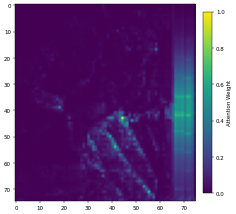

In [5]:
arr1 = np.load('atten_weight_v.npy')
attn = arr1[0,:75*75,:,:].reshape(75*75, 8*16)[:,118].reshape(75,75)
shape=75
# attn = attn / attn.sum(axis=1, keepdims=True)  # 每行归一化到1
attn = (attn - attn.min()) / (attn.max() - attn.min())

# 可选：自定义标签（也可传 None）
row_tokens = None #[f"q{i}" for i in range(shape)]
col_tokens = None# [f"k{i}" for i in range(shape)]

visualize_attention(attn,shape=shape,annotate=False,
                        # row_labels=row_tokens,
                        # col_labels=col_tokens,
                        title="Example Attention",
                        save_path="attention.png")


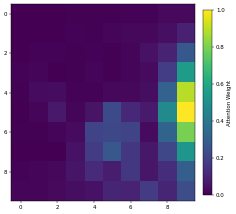

In [6]:
import torch.nn.functional as F
import torch

def _to_t4(x: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(x.astype(np.float32))[None, None]

t = _to_t4(attn)
attn75 = F.adaptive_avg_pool2d(t, (10, 10))[0,0].numpy()       
attn75 = (attn75 - attn75.min()) / (attn75.max() - attn75.min())
visualize_attention(attn75,shape=shape,annotate=False, title="Example Attention", save_path="attention.png")      

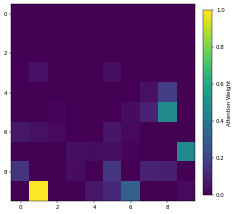

In [7]:
arr1 = np.load('biheat.npy') # [2028,656,32], 128, 100, 100, 128, 
# feat1 = arr1[0,128:228,0].reshape(10, 10)
# attn = arr1[128:228,3].reshape(10, 10)
attn = arr1[228:328,8].reshape(10, 10)


# attn = attn / attn.sum(axis=1, keepdims=True)  # 每行归一化到1
attn = (attn - attn.min()) / (attn.max() - attn.min())

# 可选：自定义标签（也可传 None）
row_tokens = [f"q{i}" for i in range(10)]
col_tokens = [f"k{i}" for i in range(10)]

visualize_attention(attn,annotate=False,
                        row_labels=row_tokens,
                        col_labels=col_tokens,
                        title="Example Attention (10x10)",
                        save_path="attention_10x10.png")


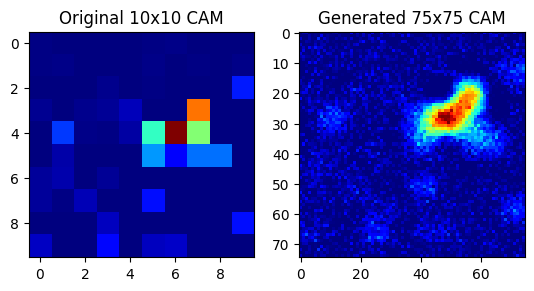

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def cam_upsample_with_noise(cam_small, target_size=(75,75), noise_scale=0.05):
    # 1. 双三次插值放大
    cam_large = cv2.resize(cam_small, target_size, interpolation=cv2.INTER_CUBIC)
    
    # 2. 加入随机噪声
    noise = np.random.normal(0, noise_scale, size=target_size)
    cam_large_noisy = cam_large + noise
    
    # 3. clip 到 [0,1]
    cam_large_noisy = np.clip(cam_large_noisy, 0, 1)
    
    return cam_large_noisy



def cam_upsample_with_smooth_noise(cam_small, target_size=(75,75), noise_scale=0.05, blur_ksize=7):
    cam_large = cv2.resize(cam_small, target_size, interpolation=cv2.INTER_CUBIC)
    
    noise = np.random.normal(0, noise_scale, size=target_size).astype(np.float32)
    noise_smooth = cv2.GaussianBlur(noise, (blur_ksize, blur_ksize), 0)
    
    cam_large_noisy = cam_large + noise_smooth
    cam_large_noisy = np.clip(cam_large_noisy, 0, 1)
    
    return cam_large_noisy

# 示例
# cam_small = np.random.rand(10,10)  # 假设一个10×10的CAM


feat = np.load('biheat.npy')[228:328,9].reshape(10, 10)
feat[8,:2] = feat[:2, 8]
feat[8,5:7] = feat[-2:, 8]
feat[6,7] = feat[6, 6]
feat[5,8] = feat[5, 7]
cam_small = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)

cam_large = cam_upsample_with_noise(cam_small)
tmp = cam_large[:5, :]
cam_large[:-5, :] = cam_large[5:, :]
cam_large[-5:, :] = tmp

# cam_large = cam_upsample_with_smooth_noise(cam_small)


plt.subplot(1,2,1)
plt.imshow(cam_small, cmap="jet")
plt.title("Original 10x10 CAM")

plt.subplot(1,2,2)
plt.imshow(cam_large, cmap="jet")
plt.title("Generated 75x75 CAM")
plt.show()


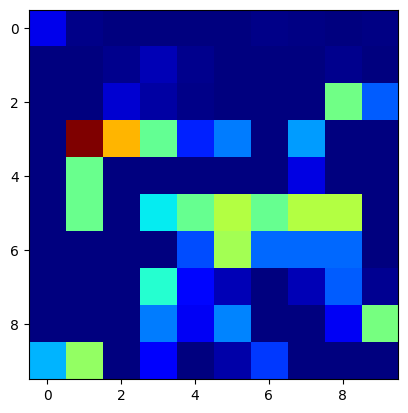

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ===== 3. 特征 -> 注意力图（归一化到 0~1）=====
def feature_to_attention(feat):
    feat_norm = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)
    return feat_norm

 # ===== 4. 定义叠加函数 =====
def overlay_attention(image, attn_map, alpha=0.5, cmap='jet'):
    attn_color = plt.get_cmap(cmap)(attn_map)[:, :, :3]  # RGBA -> RGB
    attn_color = (attn_color * 255).astype(np.uint8)
    overlayed = cv2.addWeighted(image, 1 - alpha, attn_color, alpha, 0)
    return overlayed



imgName = '/data1/zc/24forensics/CofiPara-master/data/msti/img/208.jpg'
img = cv2.imread(imgName)  # 你的原图路径
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转成RGB

feat = np.load('/data1/zc/24forensics/CofiPara-masterFC03/biheat.npy')[228:328,11].reshape(10, 10)
tmp = feat[5, 1]
feat[5, 1] = feat[4, 1]
feat[4, 1] = tmp
feat[5:7, 5:8] = feat[5:7, 6:9]

tmp = feat[5, 7:9] 
feat[5, 7:9] = feat[5, 5:7]
feat[5, 5:7] =  tmp


feat[5:7, 4:8] = feat[5:7, 5:9]

feat[3:5, 1:3] = feat[4:6, 1:3] 


attn1 = feature_to_attention(feat)
H, W, _ = img.shape
attn1_resized = cv2.resize(attn1, (W, H), interpolation=cv2.INTER_LINEAR)
overlay1 = overlay_attention(img, attn1_resized, alpha=0.5, cmap='jet')
cv2.imwrite("/data1/zc/24forensics/CofiPara-masterFC03/biweight2.png", cv2.cvtColor(overlay1, cv2.COLOR_RGB2BGR))


# feat[8,5:7] = feat[-2:, 8]
# feat[6,7] = feat[6, 6]
# feat[5,8] = feat[5, 7]
cam_small = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)
plt.imshow(cam_small, cmap="jet")


In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt
# img = Image.open()
# img.show() # 会调用系统的显示窗口
# 
# plt.figure('image')

import cv2
import numpy as np
x, y, w, h = 12,   6, 539, 358

ptLeftTop = np.array([int(x), int(y)])
ptRightBottom =np.array([int(w), int(h)])

imgPath = "/data1/zc/dataset/msti/img/37.jpg"
src = cv2.imread(imgPath)

cv2.rectangle(src, tuple(ptLeftTop), tuple(ptRightBottom), (0, 255, 0), 2, 4)
cv2.imshow('image',src)
# cv2.imwrite('test.jpg',src)


# plt.title('my boo is killing it lol # justforfun hihi # healthy # food # yummy im just kidding right ? lol emoji_131 emoji_1930 emoji_2665 emoji_689 emoji_1930 emoji_97 emoji_1778 emoji_400 emoji_131 emoji_173 emoji_92 emoji_206 emoji_206 emoji_1781')

# plt.imshow(img)
# plt.show()
